# 3 - Internal Validation with Complete Data

This Jupyter notebook contains the code to load the models obtained in the generation step, calculate performance measures on the entire IMC dataset which was used for training. It also calculates the sensitivity/specificity for different classification threhsolds from 0 to 1.

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import dateutil.parser

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from numpy import interp
from scipy.interpolate import interp1d

%matplotlib inline

This notebook evaluates different models and gives the minimum and maximum contribution from each term

In [2]:
# %load import_notebook.py
# Infraestructure to import a Jupyter notebook
# http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Importing%20Notebooks.html

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod
    
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

In [3]:
from LogRegUtils import LogRegModel
from LogRegUtils import caldis, calibration_table, calibration, calibration2
from LogRegUtils import create_plots

importing Jupyter notebook from LogRegUtils.ipynb


In [4]:
# Some utilities

def validation(ytrue, probs, thres):
    ypred = [int(thres < p) for p in probs]

    auc = roc_auc_score(ytrue, probs)
    brier = brier_score_loss(ytrue, probs)
    cal, dis = caldis(ytrue, probs)
    acc = accuracy_score(ytrue, ypred)
    precision, recall, f1score, support = precision_recall_fscore_support(ytrue, ypred)

    P = N = 0
    TP = TN = 0
    for i in range(len(ytrue)):
        if ytrue[i] == 1:
            P += 1
            if ypred[i] == 1: TP += 1
        else:
            N += 1
            if ypred[i] == 0: TN += 1

    sens = float(TP)/P            
    spec = float(TN)/N

    cfr = 100 * (float(np.sum(ytrue)) / len(ytrue))
    
    print("Number of cases :", len(ytrue)) 
    print("Number of deaths:", np.sum(ytrue)) 
    print("CFR             : %0.2f" % cfr)

    print("") 
    print("Measures of performance") 
    print("AUC           : %0.2f" % auc) 
    print("Brier         : %0.2f" % brier) 
    print("Calibration   : %0.2f" % cal) 
    print("Discrimination: %0.2f" % dis) 
    print("Accuracy      : %0.2f" % acc) 
    print("Sensitivity   : %0.2f" % sens) 
    print("Specificity   : %0.2f" % spec) 

In [5]:
sel_model = 1

risk_threshold = 0.5

make_plots = True

data_file = 'edp-data.csv'
dict_file = 'edp-dict.csv'

if sel_model == 1:
    model_name = 'age-ct-symp-model'
elif sel_model == 2:
    model_name = 'age-symp-model'  

In [6]:
# Load data, model, generate test dataset, save minmax ranges for coefficients and odd-ratios

data = pd.read_csv(data_file, na_values="\\N")

model_params = os.path.join(model_name, 'model.csv')
model_ranges= os.path.join(model_name, 'ranges.txt')
model_oddratios = os.path.join(model_name, 'oddratios.txt')
model_riskratios = os.path.join(model_name, 'riskratios.txt')

model = LogRegModel(model_params)

variables = ['Death'] + model.names

print(variables)

test_data = data[variables].dropna()
xtest = test_data[test_data.columns[1:]].values

['Death', 'PatientAge', 'CT', 'AnyBleeding', 'Diarrhoea', 'Breathlessness', 'SwallowingProblems', 'Anorexia', 'BoneMusclePain']


6.61526 - 0.37815 PatientAge + 0.00156 max(PatientAge - 2.0, 0)^3 - 0.00365 max(PatientAge - 10.0, 0)^3 + 0.00208 max(PatientAge - 16.0, 0)^3 - 0.2177 CT + 0.00062 max(CT - 18.6, 0)^3 - 0.00107 max(CT - 25.2, 0)^3 + 0.00044 max(CT - 34.5, 0)^3 + 0.32254 AnyBleeding + 0.27119 Diarrhoea + 0.40923 Breathlessness + 0.447 SwallowingProblems + 0.00738 Anorexia - 0.19712 BoneMusclePain


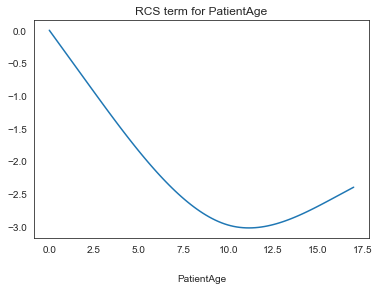

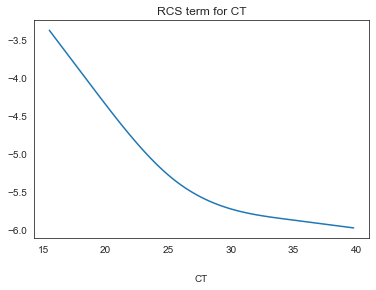

In [7]:
model.saveRanges(xtest, model_ranges)
model.loadVarTypes(data_file, dict_file)
model.saveOddRatios(xtest, model_oddratios)
model.saveRiskRatios(xtest, model_riskratios)

model.plotRCSTermsFromData(xtest, model_name)
print(model.getFormula(5))

## Performance measures for a fixed risk threshold

The following cells calculates a number of performance measures using the fixed risk (classification) threshold set in the risk_threshold variable, and the AUC and calibration curves.

In [8]:
ytrue = [int(v) for v in test_data[test_data.columns[0]].values]
probs = model.predict(xtest)
ypred = [int(risk_threshold < p) for p in probs]
validation(ytrue, probs, risk_threshold)

Number of cases : 190
Number of deaths: 67
CFR             : 35.26

Measures of performance
AUC           : 0.75
Brier         : 0.19
Calibration   : 0.00
Discrimination: 0.05
Accuracy      : 0.71
Sensitivity   : 0.37
Specificity   : 0.89


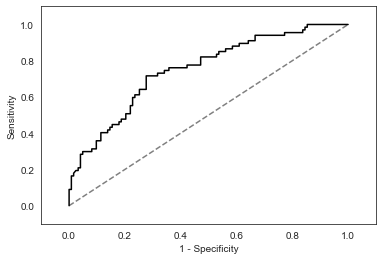

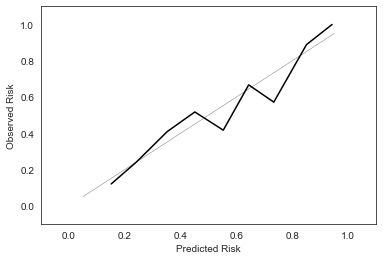

In [9]:
if make_plots:
    # ROC plot
    fpr, tpr, thresholds = roc_curve(ytrue, probs)
    fig, ax = plt.subplots()
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.plot([0, 1], [0, 1], 'k--', c='grey')
    plt.plot(fpr, tpr, color='black')
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    fig.savefig(os.path.join(model_name, 'internal-roc-complete-data.pdf'))

    # Calibration plot
    cal_table = calibration_table(ytrue, probs, 10)
    fig, ax = plt.subplots()
    plt.plot([0.05, 0.95], [0.05, 0.95], '-', c='grey', linewidth=0.5, zorder=1)
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.xlabel('Predicted Risk')
    plt.ylabel('Observed Risk')
    x = cal_table['pred_prob']
    y = cal_table['true_prob']
    # f = interp1d(x, y, kind='cubic')
    # xnew = np.linspace(min(x), max(x), num=50, endpoint=True)    
    # plt.plot(xnew, f(xnew))
    plt.plot(x, y, color='black')
    fig.savefig(os.path.join(model_name, 'internal-calibration-complete-data.pdf'))

In [10]:
# Sensitivity/specificity for an entire range of thresholds

low_thres = 0.20
med_thres = 0.35

ncells = 20
thresholds = np.linspace(0.0,  1.0,  ncells + 1)

nt = len(thresholds) - 1
interval = [str(t) + "-" + str(t + 1.0/ncells) for t in thresholds[:-1]]

sensitivity = [[] for n in range(0, nt)]
specificity = [[] for n in range(0, nt)]
surv_count = [[] for n in range(0, nt)]
died_count = [[] for n in range(0, nt)]
for n in range(0, nt):
    t = thresholds[n]
    t1 = thresholds[n + 1]
    ypred = [int(t < p) for p in probs]    
    in_cell = [t < p and p <= t1 for p in probs]    
    nsurv = 0
    ndied = 0    
    P = N = 0
    TP = TN = 0
    for i in range(len(ytrue)):
        if ytrue[i] == 1:            
            P += 1
            if ypred[i] == 1: TP += 1
            if in_cell[i]: ndied += 1
        else:
            N += 1
            if ypred[i] == 0: TN += 1
            if in_cell[i]: nsurv += 1    
            
    sens = float(TP)/P            
    spec = float(TN)/N
    
    sensitivity[n].append(sens)
    specificity[n].append(spec)
    surv_count[n].append(nsurv)
    died_count[n].append(ndied)
    
sensitivity = [np.mean(sensitivity[n]) for n in range(0, nt)]
specificity = [np.mean(specificity[n]) for n in range(0, nt)]
surv_count = [np.mean(surv_count[n]) for n in range(0, nt)]
died_count = [np.mean(died_count[n]) for n in range(0, nt)]

dfcomp = pd.DataFrame({'Threshold':pd.Series(np.array(thresholds[:-1] + 1.0/ncells)),
                       'Sensitivity':pd.Series(np.array(sensitivity)),
                       'Specificity':pd.Series(np.array(specificity)),                          
                       'Survival':pd.Series(np.array(surv_count)),
                       'Mortality':pd.Series(np.array(died_count))}, 
                        columns=['Threshold', 'Sensitivity', 'Specificity', 
                                 'Survival', 'Mortality'])

dfcomp.to_csv(os.path.join(model_name, 'sens-spec-complete.csv'))    

Low 26% 50/190 CFR=12%
Medium 26% 50/190 CFR=24%
High 47% 90/190 CFR=54%


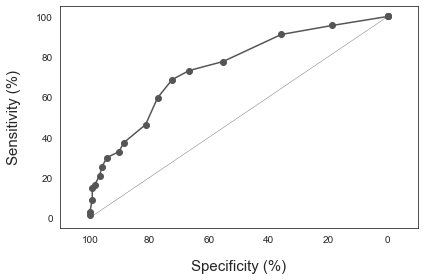

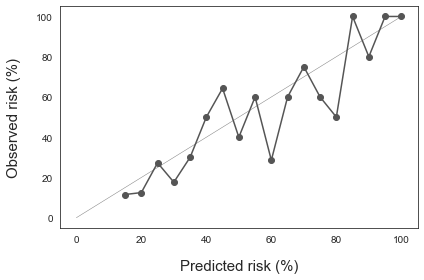

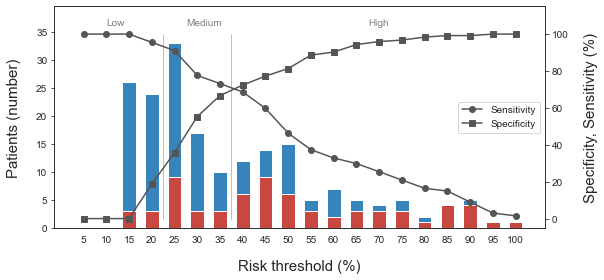

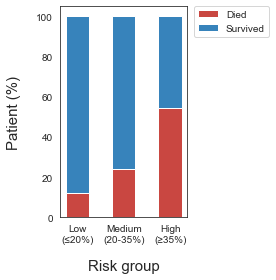

In [11]:
create_plots(model_name, dfcomp, low_thres, med_thres, 'complete')

### Calculations and plots on imputed data

In [12]:
# Odd-ratios with 95% CI
ci_critical_value = 1.96 # For 95% CI 

boot_folder = os.path.join(model_name, 'boot')
imp_folder = os.path.join(model_name, 'imp')

odds_values = {}
data_files = glob.glob(imp_folder + '/imputation-*.csv')
for fn in data_files:   
    dat = pd.read_csv(fn, na_values="\\N")[variables]
    val = dat[dat.columns[1:]].values
    
    pos0 = fn.index("imputation-") + 11
    pos1 = fn.index(".csv")
    idx = fn[pos0:pos1]
    
    odds_boot = {}
    index_files = glob.glob(boot_folder + '/index-' + idx + '-*.txt')
    model_files = glob.glob(boot_folder + '/model-' + idx + '-*.txt')
    nboot = len(index_files)
    for b in range(0, nboot):
        model = LogRegModel(model_files[b], model_format='GLM')
        model.loadVarTypes(data_file, dict_file)
        odds = model.getOddRatios(xtest)
        for k in odds:
            if not k in odds_boot: odds_boot[k] = 0
            odds_boot[k] += odds[k]

    for k in odds_boot:  
        odds_boot[k] = odds_boot[k] / nboot
    for k in odds_boot:
        if not k in odds_values: odds_values[k] = []
        if 0 < odds_boot[k] and odds_boot[k] < 100:
            odds_values[k] = odds_values[k] + [odds_boot[k]]

# Loading the model's odds
odds_model = {}
with open(model_oddratios) as f:
    lines = f.readlines()
    for line in lines:
        pieces = line.split()
        odds_model[pieces[0]] = pieces[1] 

# Adding the CIs to the model's file
with open(model_oddratios, 'w') as f:
    for k in odds_values:
        mean_odds = np.mean(odds_values[k])
        std_odds = np.std(odds_values[k])        
        ci_odds = [mean_odds - ci_critical_value * std_odds, mean_odds + ci_critical_value * std_odds]
        odds_model[k] = odds_model[k] + ' (' + str(ci_odds[0]) + ', ' + str(ci_odds[1]) + ')'    
        print(k, odds_model[k])
        f.write(k + ' ' + odds_model[k] + '\n')

PatientAge 0.0485483379404706 (0.03696001188564108, 0.06913555741832342)
PatientAge' 10.675220114888084 (7.662597987660566, 18.86338683855906)
CT 0.2049824900495001 (0.08083659353955602, 0.2800978430778774)
CT' 2.016497727672612 (1.3905469191341888, 3.3260322878883324)
AnyBleeding 1.380630852330685 (0.9179977726888942, 1.8264941861927835)
Diarrhoea 1.3115205233701615 (1.1069195324132104, 1.6508451706722358)
Breathlessness 1.5056511086806434 (1.0234456159158358, 2.1571153676750363)
SwallowingProblems 1.563610686881807 (1.2743549049682417, 1.977684479735334)
Anorexia 1.0074102838729804 (0.7753185722133065, 1.309904537768563)
BoneMusclePain 0.8210933569217437 (0.6526200269463619, 1.0652994292869562)


Mean AUC: 0.7627023850982287
95% CI: [0.7361876791170727, 0.7892170910793848]


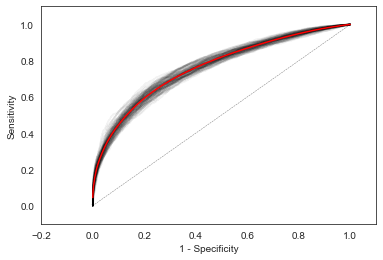

In [13]:
# Averaged ROC curve

ci_critical_value = 1.96 # For 95% CI 

boot_folder = os.path.join(model_name, 'boot')
imp_folder = os.path.join(model_name, 'imp')

fig, ax = plt.subplots()
plt.xlim([-0.2, 1.1])
plt.ylim([-0.1, 1.1])
plt.plot([0, 1], [0, 1], 'k--', c='grey', linewidth=0.5)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')

data_files = glob.glob(imp_folder + '/imputation-*.csv')
imp_fpr = []
imp_tpr = []
auc_values = []
for fn in data_files:    
    dat = pd.read_csv(fn, na_values="\\N")[variables]
    val = dat[dat.columns[1:]].values
    
    pos0 = fn.index("imputation-") + 11
    pos1 = fn.index(".csv")
    idx = fn[pos0:pos1]
    
    index_files = glob.glob(boot_folder + '/index-' + idx + '-*.txt')
    model_files = glob.glob(boot_folder + '/model-' + idx + '-*.txt')
    
    # Micro-averaging the ROC curves from bootstrap samples:
    # http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    ytrue = []
    probs = []
    ypred = []
    nboot = len(index_files)
    for b in range(0, nboot):        
        rows = []
        with open(index_files[b]) as ifile:
            lines = ifile.readlines()
            for line in lines:
                pieces = line.split()[1:]
                rows += [int(i) - 1 for i in pieces]

        ytrue += [int(v) for v in dat[dat.columns[0]].values[rows]]
        x = val[rows,:]
        model = LogRegModel(model_files[b], model_format='GLM')
        pboot = model.predict(x)
        probs += list(pboot)
        ypred += [int(0.5 < p) for p in pboot]

    auc = roc_auc_score(ytrue, probs)
    fpr, tpr, thresholds = roc_curve(ytrue, probs) 
    plt.plot(fpr, tpr, color='black', alpha=0.05)
    imp_fpr += [fpr]
    imp_tpr += [tpr]
    auc_values += [auc]

# Macro-average of ROC cuve over all imputations.

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate(imp_fpr))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(0, len(imp_fpr)):
    mean_tpr += interp(all_fpr, imp_fpr[i], imp_tpr[i])
mean_tpr /= len(imp_fpr)

# mean_auc = metrics.auc(all_fpr, mean_tpr)
mean_auc = np.mean(auc_values)
std_auc = np.std(auc_values)
ci_auc = [mean_auc - ci_critical_value * std_auc, mean_auc + ci_critical_value * std_auc]
print("Mean AUC:", mean_auc)
print("95% CI:", ci_auc)

with open(os.path.join(model_name, 'average-roc-bootstrap.txt'), 'w') as f:
    f.write(str(mean_auc) + ' (' + str(ci_auc[0]) + ',' + str(ci_auc[1]) +')')

plt.plot(all_fpr, mean_tpr, color='red', alpha=1.0)

fig.savefig(os.path.join(model_name, 'average-roc-bootstrap.pdf'))

Mean calibration: 0.04219766044255588
95% CI: [0.02471269337079358, 0.05968262751431817]


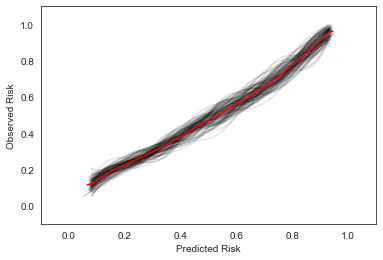

In [14]:
# Average calibration plot

boot_folder = os.path.join(model_name, 'boot')
imp_folder = os.path.join(model_name, 'imp')

fig, ax = plt.subplots()
# plt.plot([0, 1], [0, 1], '-', c='grey', linewidth=0.8 * 1, zorder=1)
plt.plot([0.05, 0.95], [0.05, 0.95], '-', c='grey', linewidth=0.5, zorder=1)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('Predicted Risk')
plt.ylabel('Observed Risk')
# lgnd = plt.legend(loc='lower right', scatterpoints=1, fontsize=10) 

data_files = glob.glob(imp_folder + '/imputation-*.csv')
imp_ppr = []
imp_tpr = []
cal_values = []
for fn in data_files:    
    dat = pd.read_csv(fn, na_values="\\N")[variables]
    val = dat[dat.columns[1:]].values
    
    pos0 = fn.index("imputation-") + 11
    pos1 = fn.index(".csv")
    idx = fn[pos0:pos1]
    
    index_files = glob.glob(boot_folder + '/index-' + idx + '-*.txt')
    model_files = glob.glob(boot_folder + '/model-' + idx + '-*.txt')
    
    ytrue = []
    probs = []
    ypred = []    
    nboot = len(index_files)
    for b in range(0, nboot):        
        rows = []
        with open(index_files[b]) as ifile:
            lines = ifile.readlines()
            for line in lines:
                pieces = line.split()[1:]
                rows += [int(i) - 1 for i in pieces]

        ytrue += [int(v) for v in dat[dat.columns[0]].values[rows]]
        x = val[rows,:]
        model = LogRegModel(model_files[b], model_format='GLM')
        pboot = model.predict(x)
        probs += list(pboot)
        ypred += [int(0.5 < p) for p in pboot]
    
    cal_table = calibration_table(ytrue, probs, 10)
    cal_values += [np.sqrt(calibration2(ytrue, probs, 10))]
    
#     sizes = cal_table['count'] / 20
#     plt.scatter(cal_table['pred_prob'], cal_table['true_prob'], s=sizes, c='red', marker='o', lw = 0, alpha=0.8, zorder=2)

    x = cal_table['pred_prob']
    y = cal_table['true_prob']
    f = interp1d(x, y, kind='cubic')
    xnew = np.linspace(min(x), max(x), num=50, endpoint=True)    
    plt.plot(xnew, f(xnew), color='black', alpha=0.1)    
    imp_ppr += [x]
    imp_tpr += [y]
  
all_ppr = np.unique(np.concatenate(imp_ppr))

mean_tpr = np.zeros_like(all_ppr)
for i in range(0, len(imp_ppr)):
    mean_tpr += interp(all_ppr, imp_ppr[i], imp_tpr[i])
mean_tpr /= len(imp_ppr)

# Won't use the mean of the cal_values obtaned from each bootstrap sample because they have, in general,
# non-uniform occupancy of the bins, so this result in abnormally low estimates of calibration, specially
# if those with high discrepancies between 
# Aggregating all predictions allow to have good occupancy, but the calibration calculation is done within
# each boostrap, so we just use the average results for the predicted and true probabilities. Also, we take 
# the square root of the calibration, so it really represents the average difference between both curves

# v = np.array(all_ppr - mean_tpr)
# mean_cal = np.sqrt(np.mean(v * v))
# print "Mean calibration:", mean_cal

mean_cal = np.mean(cal_values)
std_cal = np.std(cal_values)
ci_cal = [mean_cal - ci_critical_value * std_cal, mean_cal + ci_critical_value * std_cal]
print("Mean calibration:", mean_cal)
print("95% CI:", ci_cal)

with open(os.path.join(model_name, 'average-calibration-bootstrap.txt'), 'w') as f:
    f.write(str(mean_cal) + ' (' + str(ci_cal[0]) + ',' + str(ci_cal[1]) +')')

xnew = np.linspace(min(all_ppr), max(all_ppr), num=2 * len(all_ppr), endpoint=True)    
f = interp1d(all_ppr, mean_tpr, kind='cubic')    
plt.plot(xnew, f(xnew), color='red', alpha=1.0)

fig.savefig(os.path.join(model_name, 'average-calibration-bootstrap.pdf'))

In [15]:
# Sensitivity/Specificity plot and risk groups

low_thres = 0.1
med_thres = 0.25

ncells = 20
thresholds = np.linspace(0.0,  1.0,  ncells + 1)
nt = len(thresholds) - 1
sensitivity = [[] for n in range(0, nt)]
specificity = [[] for n in range(0, nt)]
surv_count = [[] for n in range(0, nt)]
died_count = [[] for n in range(0, nt)]

boot_folder = os.path.join(model_name, 'boot')
imp_folder = os.path.join(model_name, 'imp')

data_files = glob.glob(imp_folder + '/imputation-*.csv')
imp_ppr = []
imp_tpr = []
for fn in data_files:    
    dat = pd.read_csv(fn, na_values="\\N")[variables]
    val = dat[dat.columns[1:]].values
    
    pos0 = fn.index("imputation-") + 11
    pos1 = fn.index(".csv")
    idx = fn[pos0:pos1]
    
    index_files = glob.glob(boot_folder + '/index-' + idx + '-*.txt')
    model_files = glob.glob(boot_folder + '/model-' + idx + '-*.txt')
    
    ytrue = []
    probs = []
    ypred = []    
    nboot = len(index_files)
    for b in range(0, nboot):        
        rows = []
        with open(index_files[b]) as ifile:
            lines = ifile.readlines()
            for line in lines:
                pieces = line.split()[1:]
                rows += [int(i) - 1 for i in pieces]

        ytrue = [int(v) for v in dat[dat.columns[0]].values[rows]]
        x = val[rows,:]
        model = LogRegModel(model_files[b], model_format='GLM')
        probs = model.predict(x)
        
        for n in range(0, nt):
            t = thresholds[n]
            t1 = thresholds[n + 1]
            ypred = [int(t < p) for p in probs]    
            in_cell = [t < p and p <= t1 for p in probs]    
            nsurv = 0
            ndied = 0    
            P = N = 0
            TP = TN = 0
            for i in range(len(ytrue)):
                if ytrue[i] == 1:            
                    P += 1
                    if ypred[i] == 1: TP += 1
                    if in_cell[i]: ndied += 1
                else:
                    N += 1
                    if ypred[i] == 0: TN += 1
                    if in_cell[i]: nsurv += 1            
            sens = float(TP)/P            
            spec = float(TN)/N
    
            sensitivity[n].append(sens)
            specificity[n].append(spec)
            surv_count[n].append(nsurv)
            died_count[n].append(ndied)        
    
sensitivity = [np.mean(sensitivity[n]) for n in range(0, nt)]
specificity = [np.mean(specificity[n]) for n in range(0, nt)]
surv_count = [np.mean(surv_count[n]) for n in range(0, nt)]
died_count = [np.mean(died_count[n]) for n in range(0, nt)]

dfboot = pd.DataFrame({'Threshold':pd.Series(np.array(thresholds[:-1] + 1.0/ncells)), 
                       'Sensitivity':pd.Series(np.array(sensitivity)),
                       'Specificity':pd.Series(np.array(specificity)),                          
                       'Survival':pd.Series(np.array(surv_count)),
                       'Mortality':pd.Series(np.array(died_count))}, 
                        columns=['Threshold', 'Sensitivity', 'Specificity', 
                                 'Survival', 'Mortality'])

dfboot.to_csv(os.path.join(model_name, 'sens-spec-bootstrap.csv'))

Low 5% 12/212 CFR=11%
Medium 30% 64/212 CFR=20%
High 63% 135/212 CFR=52%


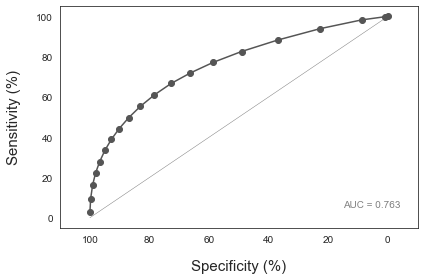

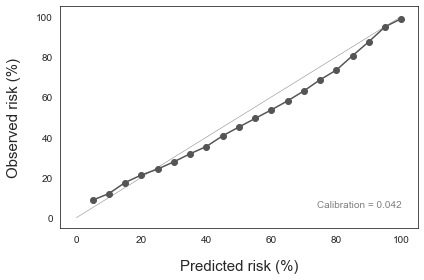

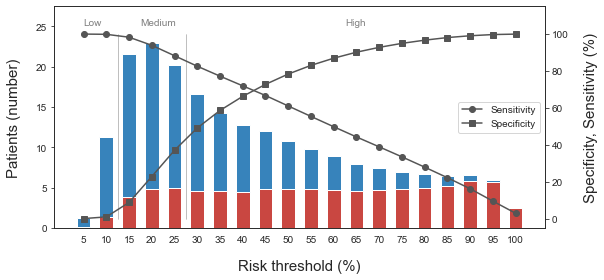

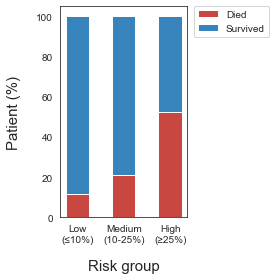

In [16]:
create_plots(model_name, dfboot, low_thres, med_thres, 'bootstrap', mean_auc, mean_cal)